The colony Prosperity-3 has been plagued by a series of mysterious disappearances.

**Clues from Senior Data Scientist:**
- The date when a colonist is last seen could be associated with their visit to one of the places equipped with ID detectors: the hairdresser's, counselor's, psychologist's, doctor's or dentist's offices.”
- Certain colonists' shifts may correspond to higher missing rates.”
- Country zip code may be important


## Setup

### Mount google drive and import libraries

In [ ]:
# Colab: mount Drive (skip if local)
from google.colab import drive
drive.mount('/content/drive')

# One-off installs (Colab)
!pip install --quiet pandas numpy scikit-learn xgboost imbalanced-learn shap

# Imports
import pandas as pd, numpy as np, shap, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data and quick peek

In [ ]:
data_dir = Path('/content/drive/MyDrive/KPMG_Case')
train   = pd.read_csv(data_dir/'data_train_fin.csv')
test    = pd.read_csv(data_dir/'data_test_fin.csv')
missing = pd.read_csv(data_dir/'missing_report.csv')
shifts  = pd.read_csv(data_dir/'shift_report.csv')

# Cell: print overview with dividers
divider = "=" * 60

print(divider)
print("DATA SHAPES")
print(divider)
print(f"Train:   {train.shape}")
print(f"Test:    {test.shape}")
print(f"Missing: {missing.shape}")
print(f"Shifts:  {shifts.shape}\n")

print(divider)
print("TRAIN SET (head)")
print(divider)
print(train.head(), "\n")

print(divider)
print("TEST SET (head)")
print(divider)
print(test.head(), "\n")

print(divider)
print("MISSING REPORT (head)")
print(divider)
print(missing.head(), "\n")

print(divider)
print("SHIFT REPORT (head)")
print(divider)
print(shifts.head())


DATA SHAPES
Train:   (10920, 13)
Test:    (4680, 13)
Missing: (276, 3)
Shifts:  (13, 6)

TRAIN SET (head)
           full_name sex      profession  hourly_salary date_of_birth  weight  \
0       Emily Holmes   f         laborer           14.0       10/2/73    84.0   
1     Vincent Harris   m    psychologist            NaN       1/11/72    72.0   
2     Matthew Wilson   m     electrician           14.0        7/6/71    66.0   
3                NaN   m  police officer           14.0       11/2/66    82.0   
4  Marilyn Rodriguez   f           clerk           16.2       1/12/65    94.0   

   height city_of_origin   last_seen  satisfaction_score  sleep_1  sleep_2  \
0   175.0     Manchester  2208-02-22            0.706897      7.0      8.8   
1   171.0        Seattle  2208-02-24            0.701149      7.9      7.6   
2   179.0        Toronto  2208-02-22            0.580460      8.5      6.2   
3   177.0       New York  2208-02-22            0.666667      9.4      8.1   
4   185.0        

## EDA and Data Preprocessing

### Build the target label (went_missing)

In [ ]:
"""
Merge missing_report into training data to create binary label
(classify colonists as missing/non-missing)

This block:
1. Reads and normalizes names from missing_report.csv to build a lookup set.
2. Normalizes each training full_name the same way.
3. Labels train['went_missing'] = 1 if the colonist’s name is in the missing report, else 0.
4. Prints counts and proportions to show class balance.
"""

# --- Helper: build normalized name keys from missing_report.csv ---
missing_keys = (
    missing['first_name']
        .str.strip()       # remove whitespace around first names
        .str.lower()       # lowercase for consistent comparison
    + ' ' +
    missing['last_name']
        .str.strip()       # remove whitespace around last names
        .str.lower()       # lowercase for consistent comparison
)

# --- Merge: label training rows based on missing report ---
train['went_missing'] = (
    train['full_name']
        .str.strip()       # remove extra spaces in full_name
        .str.lower()       # lowercase to match missing_keys format
        .isin(missing_keys)  # True if in lookup set, False otherwise
    .astype(int)          # set integer 1/0
)

# --- Evaluation: display class counts and balance ---
print(train['went_missing'].value_counts())          # show number of non-missing vs missing
print(divider)
print("CLASS BALANCE")
print(divider)
print(train['went_missing'].value_counts(normalize=True))  # show ratio of each class


went_missing
0    10660
1      260
Name: count, dtype: int64
CLASS BALANCE
went_missing
0    0.97619
1    0.02381
Name: proportion, dtype: float64


In [ ]:
# Count missing people who don't appear in training
missing_not_in_train = 0
for key in missing_keys:
    if key not in train['full_name'].str.strip().str.lower().values:
        missing_not_in_train += 1
        print(f"Missing person not found in training: {key}")

print(f"\nTotal missing people not found in training: {missing_not_in_train}")

# Check for all 276 people across both train and test sets
if 'test' in globals():
    test['normalized_name'] = test['full_name'].str.strip().str.lower()
    missing_in_test = sum(test['normalized_name'].isin(missing_keys))
    print(f"Missing people found in test set: {missing_in_test}")
    print(f"Total accounted for: {260 + missing_in_test} of 276")

Missing person not found in training: walter mercury
Missing person not found in training: gloria holmes
Missing person not found in training: benjamin williams
Missing person not found in training: cheryl proust
Missing person not found in training: william banner
Missing person not found in training: matthew nabokov
Missing person not found in training: frank anderson
Missing person not found in training: nancy dickens
Missing person not found in training: jose forster
Missing person not found in training: deborah gallager
Missing person not found in training: megan taylor
Missing person not found in training: terry roth
Missing person not found in training: ralph gallager
Missing person not found in training: jason banner
Missing person not found in training: larry huxley
Missing person not found in training: raymond fitzgerald

Total missing people not found in training: 16
Missing people found in test set: 0
Total accounted for: 260 of 276


We’ll proceed with the **260 colonists** whose missing status can be confirmed in our training set, and flag the **16 unmatched names** to the Senior Data Scientist so they can investigate the data mismatch before deployment.

### Pivot shift_report into binary on-duty flags

In [ ]:
"""
Pivot `shift_report.csv` into binary on-duty flags
(assemble training dataset; captures “ID‐detector visits” clue)

Clue: whether each colonist ever visited each ID-detector site in the last 8 days

This block:
1. Reads the raw `shifts` DataFrame with columns [date, hairdresser, counselor, …].
2. Melts it into long form to get one row per (date, venue, full_name).
3. Creates a flag = 1 for each shift entry.
4. Pivots to one row per colonist with columns `on_duty_<venue>` indicating if they worked any shift in the last 8 days.
5. Merges these flags into the `train` and `test` DataFrames, filling only the flag columns with 0 to avoid overwriting other NaNs.
"""

# Melt wide-form shifts data into long form
shifts_long = (
    shifts
    .melt(id_vars='date', var_name='venue', value_name='full_name')
    .dropna()                     # drop rows where no name was recorded
)

# Create flag column for pivot
shifts_long['flag'] = 1

# Pivot to get one row per full_name with on_duty_<venue> flags
shift_flags = (
    shifts_long
    .pivot_table(
        index='full_name',
        columns='venue',
        values='flag',
        aggfunc='max',           # if a person worked multiple days at a venue, still count as 1
        fill_value=0
    )
    .add_prefix('on_duty_')      # rename columns to on_duty_hairdresser, etc.
    .reset_index()
)

# Merge flags into training and test sets without global fillna
train = train.merge(shift_flags, on='full_name', how='left')
test  = test.merge(shift_flags,  on='full_name', how='left')

# Identify the newly added flag columns
flag_cols = [c for c in shift_flags.columns if c.startswith("on_duty_")]

# Fill only the flag columns with 0 (and cast to int)
train[flag_cols] = train[flag_cols].fillna(0).astype(int)
test[flag_cols]  = test[flag_cols].fillna(0).astype(int)

# ────── Sanity checks for on_duty flags ──────
# 1) Peek at the pivoted flags before the merge
print("SHIFT_FLAGS sample:")
print(shift_flags.head(), "\n")

# 2) Confirm the flags exist on the training set
print("TRAIN sample with on_duty flags:")
print(train[["full_name"] + flag_cols].head(), "\n")

# 3) Show how many colonists have each flag
print("On-duty counts:")
print(train[flag_cols].sum())



SHIFT_FLAGS sample:
venue          full_name  on_duty_counselor  on_duty_dentist  on_duty_doctor  \
0       Abigail Martinez                  1                0               0   
1       Anthony Vonnegut                  0                0               1   
2          Benjamin Roth                  0                0               0   
3      Beverly Hernandez                  0                0               0   
4          Bradley Woolf                  1                0               0   

venue  on_duty_hairdresser  on_duty_psychologist  
0                        0                     0  
1                        0                     0  
2                        0                     1  
3                        1                     0  
4                        0                     0   

TRAIN sample with on_duty flags:
           full_name  on_duty_counselor  on_duty_dentist  on_duty_doctor  \
0       Emily Holmes                  0                0               0   
1     

### Advanced temporal clues

In [ ]:
"""
Advanced Shift Features – recency & frequency of ID-detector visits
(capture temporal “clues” beyond simple ever-worked flags)

Clue 1: where someone was last seen (ID-detector venue on disappearance date)
Clue 2: how often they worked each detector site in the prior week

For each colonist, it pulls two key facts out of the 8-day shift log:
1. Where they were last seen: looks up which detector-equipped site (if any) they worked on their disappearance date and records that as `last_seen_venue`.
2. How often they worked each site: counts their total shifts at each of the five venues over the week and saves those as `shift_count_<venue>` columns.
Then we add those “where” and “how many” features into the main training and test tables so the model can use them.

This block:
1. Re-melts `shifts` into long form and rebuilds a lookup dict (`SHIFT_DICT`) for fast date→venue queries.
2. Creates `last_seen_venue`: the specific venue where each colonist was last detected on their `last_seen` date.
3. Builds `shift_counts_<venue>`: the total number of shifts each colonist worked in the 8-day window, per venue.
4. Merges these new features into both `train` and `test`, filling missing recency venues as 'None' and counts as 0.
5. Prints a sample to verify they look correct.
"""

# 1) Re-melt and rebuild lookup
shifts_long = (
    shifts
    .melt(id_vars='date', var_name='venue', value_name='full_name')
    .dropna()
)
# dict: date → Series mapping full_name → venue
SHIFT_DICT = {
    date: grp.set_index('full_name')['venue']
    for date, grp in shifts_long.groupby('date')
}
VENUES = [v for v in shifts.columns if v != 'date']

# 2) Recency feature: specific venue on last_seen date
def get_last_seen_venue(row):
    # look up the series for that date, then get this colonist’s venue
    venue_series = SHIFT_DICT.get(row['last_seen'], pd.Series(dtype='object'))
    return venue_series.get(row['full_name'], 'None')

for df in (train, test):
    df['last_seen_venue'] = df.apply(get_last_seen_venue, axis=1)

# 3) Frequency features: count of shifts per venue over 8 days
shift_counts = (
    shifts_long
    .groupby(['full_name','venue'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('shift_count_')
    .reset_index()
)

# Merge counts into train & test, filling zeros
train = train.merge(shift_counts, on='full_name', how='left')
test  = test.merge(shift_counts,  on='full_name', how='left')
count_cols = [c for c in shift_counts.columns if c.startswith('shift_count_')]
train[count_cols] = train[count_cols].fillna(0).astype(int)
test [count_cols] = test [count_cols].fillna(0).astype(int)

# 4) Sample check
print("Sample recency & frequency features (train):")
print(train[['full_name','last_seen','last_seen_venue'] + count_cols].head(), "\n")
print("Total shift counts per venue:")
print(train[count_cols].sum())

Sample recency & frequency features (train):
           full_name   last_seen last_seen_venue  shift_count_counselor  \
0       Emily Holmes  2208-02-22            None                      0   
1     Vincent Harris  2208-02-24            None                      0   
2     Matthew Wilson  2208-02-22            None                      0   
3                NaN  2208-02-22            None                      0   
4  Marilyn Rodriguez  2208-02-24            None                      0   

   shift_count_dentist  shift_count_doctor  shift_count_hairdresser  \
0                    0                   0                        0   
1                    0                   0                        0   
2                    0                   0                        0   
3                    0                   0                        0   
4                    0                   0                        0   

   shift_count_psychologist  
0                         0  
1                

In [ ]:
"""
Verify `last_seen_venue` feature – show non‐None occurrences
(sanity-check advanced shift feature)

This block:
1. Filters the training set for rows where `last_seen_venue` is not 'None'.
2. Prints a sample of these entries so you can confirm the correct mapping.
3. Shows the total count of such occurrences.

"""

# 1) Filter for actual last_seen_venue entries
occurrences = train[train['last_seen_venue'] != 'None']

# 2) Display a sample (first 10) to verify
print("Sample rows where last_seen_venue is not 'None':\n")
print(occurrences[['full_name', 'last_seen', 'last_seen_venue']].head(10), "\n")

# 3) Print total number of such cases
print(f"Total colonists with a recorded last_seen_venue: {len(occurrences)}")



Sample rows where last_seen_venue is not 'None':

             full_name   last_seen last_seen_venue
1131    Patrick Lennon  2208-02-23          doctor
2647     Shirley Kafka  2208-02-16         dentist
3008     Joseph Watson  2208-02-24       counselor
4135   Jason Hernandez  2208-02-24     hairdresser
5564       Paul Waters  2208-02-22       counselor
5987   Philip Gonzalez  2208-02-24         dentist
6966     Christian Lee  2208-02-23     hairdresser
7553   Laura Mikkelsen  2208-02-22         dentist
9435     Jordan Garcia  2208-02-18       counselor
10261   Brandon O'Hara  2208-02-23       counselor 

Total colonists with a recorded last_seen_venue: 10


### Age and last_seen recency

In [ ]:
"""
Feature Engineering – Age & Recency
(enriching dataset with predictive clues)

This block:
1. Parses the two-digit ‘date_of_birth’ into full datetimes.
2. Computes `age` in years as of the reference date (2208-02-24).
3. Parses `last_seen` into datetimes.
4. Computes:
   - `days_since_last_seen`: days between last_seen and reference date.
   - `last_seen_dow`: day-of-week of last_seen (0=Mon…6=Sun).
"""

from datetime import datetime

# Reference date for all recency calculations
REF_DATE  = pd.Timestamp('2208-02-24')
REF_YY    = REF_DATE.year % 100  # two-digit pivot (08)

def parse_birth(datestr: str) -> pd.Timestamp:
    """
    Parse MM/DD/YY into a full Timestamp:
      - YY ≤ REF_YY → year = 2200 + YY
      - else          → year = 2100 + YY
    Returns pd.NaT if invalid.
    """
    try:
        m, d, yy = map(int, datestr.split('/'))
    except Exception:
        return pd.NaT
    year = 2200 + yy if yy <= REF_YY else 2100 + yy
    try:
        return datetime(year, m, d)
    except ValueError:
        return pd.NaT


# --- 1) Parse birthdates & compute age ---
train['dob_parsed'] = pd.to_datetime(train['date_of_birth'].apply(parse_birth))
train['age']        = ((REF_DATE - train['dob_parsed']).dt.days // 365).astype('Int64')

# --- 2) Parse last_seen & compute recency features ---
train['last_seen_parsed']    = pd.to_datetime(train['last_seen'], errors='coerce')
train['days_since_last_seen'] = (REF_DATE - train['last_seen_parsed']).dt.days.astype('Int64')
train['last_seen_dow']        = train['last_seen_parsed'].dt.dayofweek.astype('Int64')

# ----- on TEST -----
test['dob_parsed']         = pd.to_datetime(test['date_of_birth'].apply(parse_birth))
test['age']                = ((REF_DATE - test['dob_parsed']).dt.days // 365).astype('Int64')

test['last_seen_parsed']   = pd.to_datetime(test['last_seen'], errors='coerce')
test['days_since_last_seen'] = (REF_DATE - test['last_seen_parsed']).dt.days.astype('Int64')
test['last_seen_dow']      = test['last_seen_parsed'].dt.dayofweek.astype('Int64')

# --- Quick peek ---
print("Sample age & recency features (train):")
print(train[['full_name','date_of_birth','dob_parsed','age',
             'last_seen','last_seen_parsed','days_since_last_seen',
             'last_seen_dow']].head(), "\n")

print("Sample age & recency (test):")
print(test[['full_name','date_of_birth','dob_parsed','age',
             'last_seen','last_seen_parsed','days_since_last_seen',
             'last_seen_dow']].head(), "\n")


Sample age & recency features (train):
           full_name date_of_birth dob_parsed  age   last_seen  \
0       Emily Holmes       10/2/73 2173-10-02   34  2208-02-22   
1     Vincent Harris       1/11/72 2172-01-11   36  2208-02-24   
2     Matthew Wilson        7/6/71 2171-07-06   36  2208-02-22   
3                NaN       11/2/66 2166-11-02   41  2208-02-22   
4  Marilyn Rodriguez       1/12/65 2165-01-12   43  2208-02-24   

  last_seen_parsed  days_since_last_seen  last_seen_dow  
0       2208-02-22                     2              0  
1       2208-02-24                     0              2  
2       2208-02-22                     2              0  
3       2208-02-22                     2              0  
4       2208-02-24                     0              2   

Sample age & recency (test):
        full_name date_of_birth dob_parsed   age   last_seen last_seen_parsed  \
0    Ryan Weasley       2/15/83 2183-02-15    25  2208-02-23       2208-02-23   
1  Jason Bradbury      

### Sleep metrics

In [ ]:
"""
Compute Sleep Metrics – average, variability & delta
(enrich dataset with additional “clues” related to sleep patterns)

This block:
1. Calculates `sleep_avg`: mean hours across the three sleep periods.
2. Calculates `sleep_std`: standard deviation to capture variability.
3. Calculates `sleep_delta`: difference between period 3 and period 1 to see trends.
"""

# 1) Sleep metrics on training set
train['sleep_avg']   = train[['sleep_1','sleep_2','sleep_3']].mean(axis=1)
train['sleep_std']   = train[['sleep_1','sleep_2','sleep_3']].std(axis=1)
train['sleep_delta'] = train['sleep_3'] - train['sleep_1']

# 2) Sleep metrics on test set
test['sleep_avg']    = test[['sleep_1','sleep_2','sleep_3']].mean(axis=1)
test['sleep_std']    = test[['sleep_1','sleep_2','sleep_3']].std(axis=1)
test['sleep_delta']  = test['sleep_3'] - test['sleep_1']

# Quick sanity check
print("Sample sleep metrics (train):")
print(train[['full_name','sleep_1','sleep_2','sleep_3','sleep_avg','sleep_std','sleep_delta']].head(), "\n")



Sample sleep metrics (train):
           full_name  sleep_1  sleep_2  sleep_3  sleep_avg  sleep_std  \
0       Emily Holmes      7.0      8.8     11.3   9.033333   2.159475   
1     Vincent Harris      7.9      7.6      9.0   8.166667   0.737111   
2     Matthew Wilson      8.5      6.2      8.0   7.566667   1.209683   
3                NaN      9.4      8.1      8.5   8.666667   0.665833   
4  Marilyn Rodriguez      8.9      NaN      8.1   8.500000   0.565685   

   sleep_delta  
0          4.3  
1          1.1  
2         -0.5  
3         -0.9  
4         -0.8   



### Zip_code and nationality mapping

In [ ]:
# 1) List all unique cities in your data
import pandas as pd

unique_cities = pd.Series(
    pd.concat([train['city_of_origin'], test['city_of_origin']])
).dropna().str.strip().unique()

print("Unique cities needing mapping:")
for city in sorted(unique_cities):
    print(city)


Unique cities needing mapping:
Birmingham
Brisbane
London
Los Angeles
Manchester
Melbourne
Montreal
New York
Seattle
Sydney
Toronto
Vancouver


In [ ]:
"""
Map city_of_origin → zip_code → ordinal encoding
(encode geographic “clues” with clear pedagogical notes)

This block:
1. Uses the Senior Data Scientist’s hint to map each city_of_origin into a zip_code string:
   - '001' for AU cities, '002' for CA, '003' for GB, '004' for US, and 'UNK' for any others.
2. Explains why we also create an ordinal numeric version (`zip_code_ord`):
   - Some models (like tree-based classifiers) can directly handle integer categories.
   - Ordinal codes are compact and let us compare categories via numerical pipelines.
   - Caution: ordinal encoding implies an order which may not truly exist;
     for non-ordinal algorithms or if order matters wrongly, one-hot encoding is safer.
3. Provides both string and ordinal representations so you can choose later.
4. Prints distributions so you can verify the mapping.

"""

# 1) Manual city → zip mapping (per KPMG hint)
city_to_zip = {
    # Australia (AU) → 001
    'Brisbane':   '001',
    'Melbourne':  '001',
    'Sydney':     '001',
    # Canada (CA) → 002
    'Montreal':   '002',
    'Toronto':    '002',
    'Vancouver':  '002',
    # United Kingdom (GB) → 003
    'London':     '003',
    'Birmingham': '003',
    'Manchester': '003',
    # United States (US) → 004
    'New York':   '004',
    'Los Angeles':'004',
    'Seattle':    '004'
}

# 2) Apply mapping to train and test, filling any other cities as 'UNK'
for df in (train, test):
    df['zip_code'] = df['city_of_origin'].map(city_to_zip).fillna('UNK')

# 3) Ordinal encoding: map zip_code strings to integers
zip_ord = {'UNK':0, '001':1, '002':2, '003':3, '004':4}
for df in (train, test):
    df['zip_code_ord'] = df['zip_code'].map(zip_ord).astype('int8')

# 4) Sanity-check: show zip_code distribution in train
print("Zip-code distribution (train):")
print(train['zip_code'].value_counts(), "\n")
print("Ordinal zip_code distribution (train):")
print(train['zip_code_ord'].value_counts())


Zip-code distribution (train):
zip_code
004    2629
001    2624
002    2600
003    2534
UNK     533
Name: count, dtype: int64 

Ordinal zip_code distribution (train):
zip_code_ord
4    2629
1    2624
2    2600
3    2534
0     533
Name: count, dtype: int64


### Correlation of all numeric and categorical features in 'train'


All Features Association Metrics (sorted by strength):



,feature,type,metric,pval,abs_metric
0,height,numeric,-0.183,4.41e-79,0.183
1,age,numeric,0.174,6.74e-71,0.174
2,weight,numeric,0.159,1.34e-59,0.159
3,last_seen,categorical,0.127,2.48e-33,0.127
4,city_of_origin,categorical,0.094,1.7e-17,0.094
5,zip_code,categorical,0.091,1.01e-19,0.091
6,sleep_avg,numeric,-0.071,1.08e-13,0.071
7,satisfaction_score,numeric,-0.071,6.05e-13,0.071
8,days_since_last_seen,numeric,-0.071,7.05e-13,0.071
9,zip_code_ord,numeric,-0.064,2.47e-11,0.064


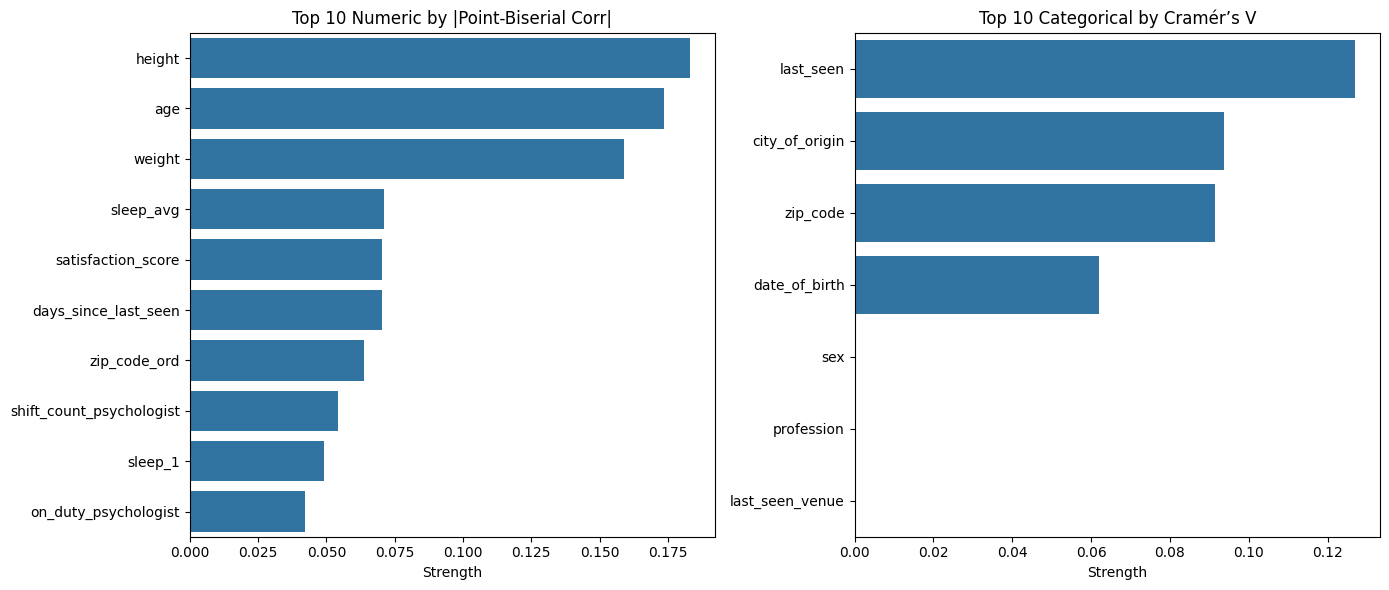

In [ ]:
"""
Unified Association Metrics for Numeric & Categorical Features
(compare all “clues” in one view)

This block:
1. Computes point-biserial corr & p-value for each numeric feature.
2. Computes Cramér’s V & chi-square p-value for each categorical feature.
3. Merges into one DataFrame sorted by absolute strength.
4. Plots two bar charts: top 10 numeric by |corr|, top 10 categorical by V.
"""

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Helper for Cramér’s V
def cramers_v(conf):
    chi2, p, dof, exp = stats.chi2_contingency(conf)
    n = conf.values.sum()
    phi2 = chi2/n
    r, k = conf.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))

# 1) Numeric associations
num_cols = train.select_dtypes(include='number').columns.drop('went_missing')
num_recs = []
for col in num_cols:
    sub = train[[col,'went_missing']].dropna()
    corr, p = stats.pointbiserialr(sub['went_missing'], sub[col])
    num_recs.append({'feature': col, 'type':'numeric', 'metric': corr, 'pval': p})
num_df = pd.DataFrame(num_recs)

# 2) Categorical associations
cat_cols = train.select_dtypes(include=['object','category']).columns.drop(['full_name','went_missing'], errors='ignore')
cat_recs = []
for col in cat_cols:
    conf = pd.crosstab(train[col].fillna('##MISSING##'), train['went_missing'])
    v = cramers_v(conf)
    _, p, _, _ = stats.chi2_contingency(conf)
    cat_recs.append({'feature': col, 'type':'categorical', 'metric': v, 'pval': p})
cat_df = pd.DataFrame(cat_recs)

# 3) Combine & sort
all_df = pd.concat([num_df, cat_df], ignore_index=True)
all_df['abs_metric'] = all_df['metric'].abs()
all_df = all_df.sort_values('abs_metric', ascending=False).reset_index(drop=True)

# 4) Display
print("\nAll Features Association Metrics (sorted by strength):\n")
display(all_df.style.format({'metric':'{:.3f}','pval':'{:.3g}','abs_metric':'{:.3f}'}))

# 5) Bar plots
fig, axes = plt.subplots(1,2, figsize=(14,6))
# Numeric top 10
top_num = all_df[all_df['type']=='numeric'].head(10)
sns.barplot(x='abs_metric', y='feature', data=top_num, ax=axes[0])
axes[0].set_title('Top 10 Numeric by |Point-Biserial Corr|')
# Categorical top 10
top_cat = all_df[all_df['type']=='categorical'].head(10)
sns.barplot(x='abs_metric', y='feature', data=top_cat, ax=axes[1])
axes[1].set_title('Top 10 Categorical by Cramér’s V')
for ax in axes:
    ax.set_xlabel('Strength')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()


### Span of age, height, weight, recency

In [ ]:
"""
Inspect spans of Age, Height, Weight & Recency

This block:
1. Computes descriptive stats (min, max, mean, std) for:
   - `age`                   (years since birth)
   - `height`                (cm)
   - `weight`                (kg)
   - `days_since_last_seen`  (days since last known sighting)
2. Prints them so you can verify there are no impossible or extreme values.
"""

# 1) Get summary stats for the four key numeric features
span_stats = train[['age', 'height', 'weight', 'days_since_last_seen']].describe().T[['min', 'max', 'mean', 'std']]

# 2) Print table
print("Summary of Age, Height, Weight & Recency spans:\n")
print(span_stats)


Summary of Age, Height, Weight & Recency spans:

                        min    max        mean        std
age                     8.0   48.0   27.694045  11.502099
height                160.0  199.0  179.535065  11.548769
weight                 65.0   94.0   79.502941   8.695684
days_since_last_seen    0.0   12.0    4.231573   4.026271


### Inspect sex distribution and missing-rate

In [ ]:
"""
Inspect Sex distribution & missing‐rate
(ensure sex categories are balanced and check their target rates)

This block:
1. Shows counts of each `sex` value.
2. Computes the proportion of colonists who went missing, grouped by `sex`.
3. Prints a table so you can see whether males or females differ in missing‐rate.
"""

# 1) Frequency of each sex
sex_counts = train['sex'].value_counts(dropna=False)
print("Sex distribution (train):")
print(sex_counts, "\n")

# 2) Missing‐rate by sex
sex_rate = train.groupby('sex')['went_missing'].mean().rename('missing_rate')
print("Missing rate by sex:")
print(sex_rate)


Sex distribution (train):
sex
f      5210
m      5183
NaN     527
Name: count, dtype: int64 

Missing rate by sex:
sex
f    0.023992
m    0.023924
Name: missing_rate, dtype: float64


### Compute BMI

In [ ]:
"""
Compute Body-Mass Index (BMI)
(derive a combined health feature)

This block:
1. Calculates `bmi` = weight(kg) / (height(cm)/100)^2 on both train & test.
2. Displays summary stats so you can see its distribution.
3. (Optional) Computes its point-biserial correlation with `went_missing`.
"""

# 1) Compute BMI
for df in (train, test):
    df['bmi'] = df['weight'] / (df['height']/100)**2

# 2) Quick summary of BMI
print("BMI summary (train):")
print(train['bmi'].describe(), "\n")

# 3) Optional: check its correlation with the target
from scipy.stats import pointbiserialr
sub = train[['bmi','went_missing']].dropna()
corr_bmi, pval_bmi = pointbiserialr(sub['went_missing'], sub['bmi'])
print(f"Point-Biserial corr(bmi, went_missing) = {corr_bmi:.3f} (p={pval_bmi:.2g})")


BMI summary (train):
count    9867.000000
mean       24.965029
std         4.249744
min        16.413727
25%        21.799445
50%        24.535124
75%        27.776930
max        36.718750
Name: bmi, dtype: float64 

Point-Biserial corr(bmi, went_missing) = 0.263 (p=2e-155)


### Range bins for age, height, weight, days_since_last_seen

In [ ]:
import pandas as pd

def make_range_bins(df, var, q=[0, .25, .5, .75, 1.0], unit=""):
    # 1) Compute the cut points (including min & max)
    edges = df[var].quantile(q).round(0).astype(int).tolist()
    # 2) Build human-friendly labels
    labels = [f"{edges[i]}–{edges[i+1]}{unit}" for i in range(len(edges)-1)]
    # 3) Create the bins on both train & test
    train[f'{var}_bin'] = pd.cut(
        train[var],
        bins=edges,
        labels=labels,
        include_lowest=True
    )
    test [f'{var}_bin'] = pd.cut(
        test[var],
        bins=edges,
        labels=labels,
        include_lowest=True
    )
    return labels

# Apply to age, height, weight
age_labels   = make_range_bins(train, 'age',    unit=' yrs')
height_labels= make_range_bins(train, 'height', unit=' cm')
weight_labels= make_range_bins(train, 'weight', unit=' kg')

# Recency we keep our custom bins
recency_bins   = [-1, 1, 3, 7, train['days_since_last_seen'].max()]
recency_labels = ['0 days','1–3 days','4–7 days','8+ days']
train['recency_bin'] = pd.cut(
    train['days_since_last_seen'], bins=recency_bins, labels=recency_labels
)
test ['recency_bin'] = pd.cut(
    test ['days_since_last_seen'], bins=recency_bins, labels=recency_labels
)

# Inspect missing-rates for the new, range-labeled bins
for var, labs in [
    ('age_bin', age_labels),
    ('height_bin', height_labels),
    ('weight_bin', weight_labels),
    ('recency_bin', recency_labels)
]:
    rates = train.groupby(var, observed=False)['went_missing'].mean()
    counts= train[var].value_counts().loc[rates.index]
    print(f"\nMissing rate by {var}:")
    print(pd.DataFrame({'rate': rates, 'count': counts}))



Missing rate by age_bin:
               rate  count
age_bin                   
8–18 yrs   0.000362   2765
18–28 yrs  0.003418   2633
28–38 yrs  0.024990   2601
38–48 yrs  0.073243   2362

Missing rate by height_bin:
                rate  count
height_bin                 
160–170 cm  0.072972   2823
170–179 cm  0.013025   2380
179–189 cm  0.003458   2603
189–199 cm  0.000000   2589

Missing rate by weight_bin:
                rate  count
weight_bin                 
65–72 kg    0.000360   2778
72–80 kg    0.006902   2753
80–87 kg    0.029228   2395
87–94 kg    0.063804   2445

Missing rate by recency_bin:
                 rate  count
recency_bin                 
0 days       0.030502   3803
1–3 days     0.041592   1683
4–7 days     0.017576   2162
8+ days      0.009665   2690


### Staff-family connection


=== FAMILY CONNECTION ANALYSIS ===
Missing rate for people WITH staff surnames: 0.0297
Missing rate for people WITHOUT staff surnames: 0.0195
Risk ratio: 1.5x higher risk with staff surname
Population with staff surnames: 4576 people

=== TOP STAFF WITH MISSING FAMILY MEMBERS ===

Top staff with missing family members:
Isabella McConaughey (hairdresser): 8 missing relatives
Marie McConaughey (dentist): 8 missing relatives
Isabella Huxley (hairdresser): 7 missing relatives
Anthony Vonnegut (doctor): 7 missing relatives
Joan Griffin (psychologist): 6 missing relatives
Christian Lee (hairdresser): 6 missing relatives
Michael Lee (counselor): 6 missing relatives
Brandon Weasley (dentist): 6 missing relatives
Kelly Granger (counselor): 6 missing relatives
Donna Smith (psychologist): 6 missing relatives

=== DATE CLUSTERING OF DISAPPEARANCES ===
2208-02-24: 116 people disappeared
2208-02-22: 49 people disappeared
2208-02-14: 26 people disappeared
2208-02-21: 21 people disappeared
2208-02-20

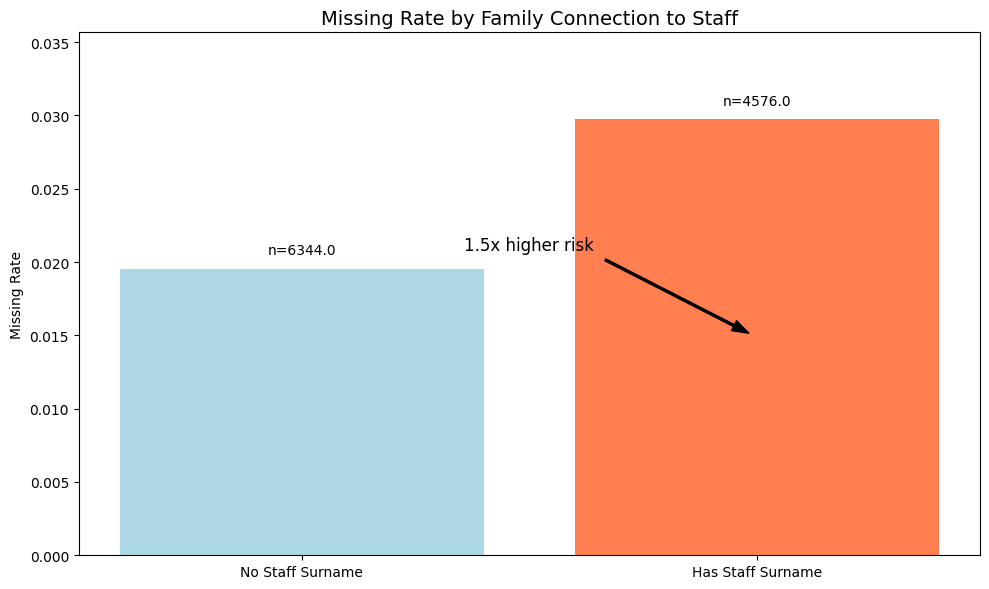


=== KEY INSIGHTS SUMMARY ===
1. Family Connection Impact:
   - People with staff surnames are 1.5205x more likely to go missing
   - 40 staff members have missing relatives

2. Most Notable Staff-Family Connections:
   - Isabella McConaughey (hairdresser): 8 missing family members
   - Marie McConaughey (dentist): 8 missing family members
   - Isabella Huxley (hairdresser): 7 missing family members
   - Anthony Vonnegut (doctor): 7 missing family members
   - Joan Griffin (psychologist): 6 missing family members
   - Christian Lee (hairdresser): 6 missing family members
   - Michael Lee (counselor): 6 missing family members
   - Brandon Weasley (dentist): 6 missing family members
   - Kelly Granger (counselor): 6 missing family members
   - Donna Smith (psychologist): 6 missing family members
   - Frances Gallager (hairdresser): 5 missing family members
   - Kathryn Gallager (counselor): 5 missing family members
   - Frank Jagger (psychologist): 5 missing family members
   - Steven Le

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

if 'date' in shifts.columns:
    shifts['date'] = pd.to_datetime(shifts['date'], errors='coerce')

# 3. Extract all staff surnames
# ─────────────────────────────────────────────────────────────
# FAMILY-STAFF CONNECTION FEATURE
# ─────────────────────────────────────────────────────────────
staff_cols = ['hairdresser','counselor','psychologist','doctor','dentist']

# collect all unique staff names from the shift table
all_staff = pd.concat([shifts[c] for c in staff_cols]).dropna().unique()
staff_surnames = {name.split()[-1]                     # fast set lookup
                  for name in all_staff                # keep only real names
                  if isinstance(name, str) and len(name.split()) > 1}

def add_surname_feature(df):
    df = df.copy()
    df['has_staff_surname'] = df['full_name']          \
        .str.split().str[-1].isin(staff_surnames).astype(int)
    return df

train = add_surname_feature(train)
test  = add_surname_feature(test)

# 5. Analyze risk by surname connection
surname_stats = train.groupby('has_staff_surname')['went_missing'].agg(['mean', 'count'])
risk_ratio = surname_stats.loc[1, 'mean'] / surname_stats.loc[0, 'mean']

print("\n=== FAMILY CONNECTION ANALYSIS ===")
print(f"Missing rate for people WITH staff surnames: {surname_stats.loc[1, 'mean']:.4f}")
print(f"Missing rate for people WITHOUT staff surnames: {surname_stats.loc[0, 'mean']:.4f}")
print(f"Risk ratio: {risk_ratio:.1f}x higher risk with staff surname")
print(f"Population with staff surnames: {surname_stats.loc[1, 'count']} people")

# 6. Identify specific staff with missing family members
print("\n=== TOP STAFF WITH MISSING FAMILY MEMBERS ===")
missing_by_staff = {}

# For each missing person with a surname match
missing_relatives = train[(train['went_missing'] == 1) & (train['has_staff_surname'] == 1)]
for _, missing in missing_relatives.iterrows():
    missing_surname = missing['full_name'].split()[-1]

    # Find which staff members have this surname
    for staff_member in all_staff:
        if isinstance(staff_member, str) and staff_member.endswith(f" {missing_surname}"):
            # Find role
            for role in staff_cols:
                if staff_member in shifts[role].values:
                    key = f"{staff_member} ({role})"
                    if key not in missing_by_staff:
                        missing_by_staff[key] = 0
                    missing_by_staff[key] += 1

# Show top staff with missing relatives
print("\nTop staff with missing family members:")
sorted_staff = sorted(missing_by_staff.items(), key=lambda x: x[1], reverse=True)
for staff, count in sorted_staff[:10]:
    print(f"{staff}: {count} missing relatives")

# 7. Analyze date patterns of disappearances
if 'last_seen' in train.columns:
    train['last_seen'] = pd.to_datetime(train['last_seen'], errors='coerce')

    # Count disappearances by date
    missing_dates = train[train['went_missing'] == 1]['last_seen'].dt.date.value_counts()

    print("\n=== DATE CLUSTERING OF DISAPPEARANCES ===")
    for date, count in missing_dates.sort_values(ascending=False).items():
        if pd.notna(date):
            print(f"{date}: {count} people disappeared")

# 9. Visualize the family connection risk
plt.figure(figsize=(10, 6))

# Plot missing rate by family connection
bars = plt.bar(['No Staff Surname', 'Has Staff Surname'],
               [surname_stats.loc[0, 'mean'], surname_stats.loc[1, 'mean']],
               color=['lightblue', 'coral'])

# Add count labels
for i, bar in enumerate(bars):
    count = surname_stats.iloc[i]['count']
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f"n={count}", ha='center')

plt.title('Missing Rate by Family Connection to Staff', fontsize=14)
plt.ylabel('Missing Rate')
plt.ylim(0, max(surname_stats['mean']) * 1.2)  # Add some space for labels

# Add the risk ratio as text
plt.annotate(f"{risk_ratio:.1f}x higher risk",
             xy=(1, surname_stats.loc[1, 'mean']/2),
             xytext=(0.5, surname_stats.loc[1, 'mean'] * 0.7),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, ha='center')

plt.tight_layout()
plt.savefig('family_connection_risk.png', dpi=300)
plt.show()

# 10. Key Insights Summary
print("\n=== KEY INSIGHTS SUMMARY ===")
print("1. Family Connection Impact:")
print(f"   - People with staff surnames are {risk_ratio:.4f}x more likely to go missing")
print(f"   - {len(sorted_staff)} staff members have missing relatives")

print("\n2. Most Notable Staff-Family Connections:")
for staff, count in sorted_staff[:]:
    print(f"   - {staff}: {count} missing family members")

print("\n3. Date Clustering:")
top_dates = missing_dates.sort_values(ascending=False)
print("   Most disappearances occurred on:")
for date, count in top_dates.items():
    if pd.notna(date):
        print(f"   - {date}: {count} people")

### Missing values

In [ ]:
"""
Audit missing values
(identify which features need imputation)

This block:
1. Counts nulls per column in `train`, including the newly created features.
2. Computes the percent missing to prioritize.
3. Prints a concise summary to guide our next imputation step.
"""

# 1) Count nulls per column
null_counts = train.isna().sum().sort_values(ascending=False)

# 2) Compute percent missing
null_percents = (null_counts / len(train) * 100).round(2)

# 3) Build and display the summary of columns with any missing values
missing_summary = pd.DataFrame({
    'n_missing':   null_counts,
    'pct_missing': null_percents
}).loc[null_counts > 0]

print("MISSING VALUE SUMMARY:\n")
print(missing_summary)


MISSING VALUE SUMMARY:

                      n_missing  pct_missing
sleep_delta                1118        10.24
bmi                        1053         9.64
sleep_3                     593         5.43
last_seen_dow               582         5.33
days_since_last_seen        582         5.33
recency_bin                 582         5.33
last_seen_parsed            582         5.33
last_seen                   582         5.33
hourly_salary               569         5.21
age                         559         5.12
age_bin                     559         5.12
date_of_birth               559         5.12
dob_parsed                  559         5.12
sleep_1                     557         5.10
weight                      549         5.03
weight_bin                  549         5.03
sleep_2                     542         4.96
profession                  537         4.92
full_name                   534         4.89
city_of_origin              533         4.88
satisfaction_score          529

### Correlation of all numeric and categorical features in 'train' 2.


All Features Association Metrics (sorted by strength):



,feature,type,metric,pval,abs_metric
0,bmi,numeric,0.263,1.99e-155,0.263
1,height,numeric,-0.183,4.41e-79,0.183
2,age,numeric,0.174,6.74e-71,0.174
3,weight,numeric,0.159,1.34e-59,0.159
4,last_seen,categorical,0.127,2.48e-33,0.127
5,city_of_origin,categorical,0.094,1.7e-17,0.094
6,zip_code,categorical,0.091,1.01e-19,0.091
7,sleep_avg,numeric,-0.071,1.08e-13,0.071
8,satisfaction_score,numeric,-0.071,6.05e-13,0.071
9,days_since_last_seen,numeric,-0.071,7.05e-13,0.071


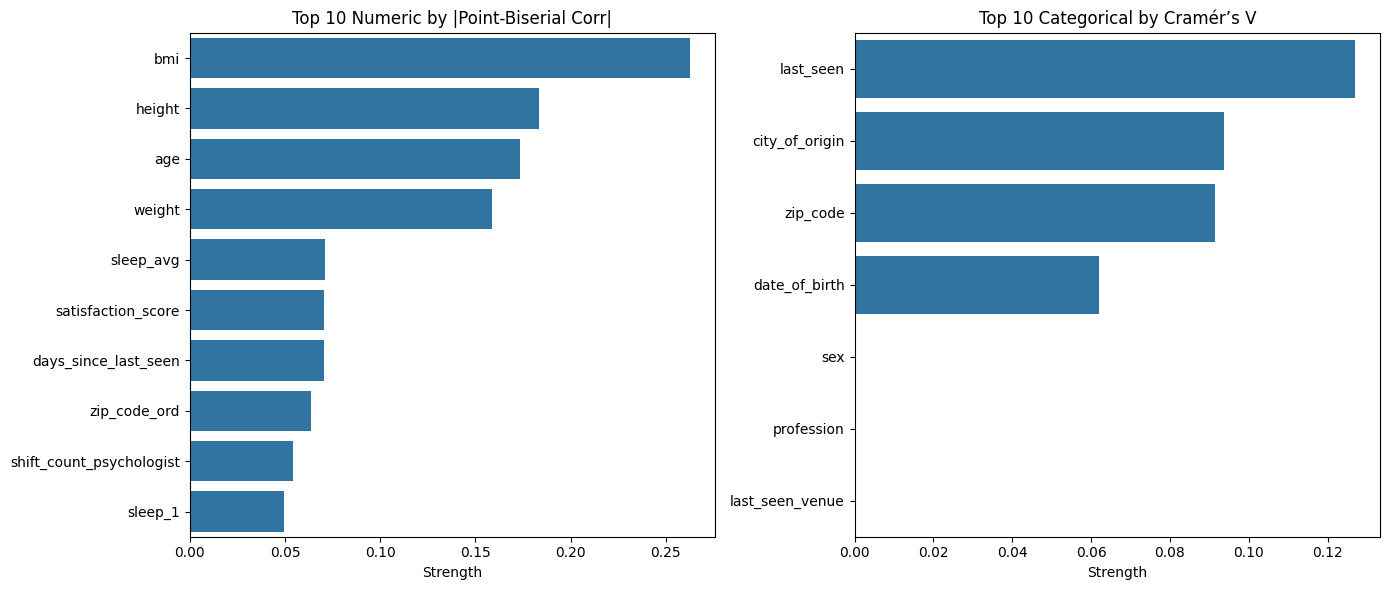

In [ ]:
"""
Unified Association Metrics for Numeric & Categorical Features
(compare all “clues” in one view)

This block:
1. Computes point-biserial corr & p-value for each numeric feature.
2. Computes Cramér’s V & chi-square p-value for each categorical feature.
3. Merges into one DataFrame sorted by absolute strength.
4. Plots two bar charts: top 10 numeric by |corr|, top 10 categorical by V.
"""

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Helper for Cramér’s V
def cramers_v(conf):
    chi2, p, dof, exp = stats.chi2_contingency(conf)
    n = conf.values.sum()
    phi2 = chi2/n
    r, k = conf.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))

# 1) Numeric associations
num_cols = train.select_dtypes(include='number').columns.drop('went_missing')
num_recs = []
for col in num_cols:
    sub = train[[col,'went_missing']].dropna()
    corr, p = stats.pointbiserialr(sub['went_missing'], sub[col])
    num_recs.append({'feature': col, 'type':'numeric', 'metric': corr, 'pval': p})
num_df = pd.DataFrame(num_recs)

# 2) Categorical associations
cat_cols = train.select_dtypes(include=['object','category']).columns.drop(['full_name','went_missing'], errors='ignore')
cat_recs = []
for col in cat_cols:
    ser = train[col]
    if ser.dtype.name == 'category':
        ser = ser.cat.add_categories('##MISSING##')
    filled = ser.fillna('##MISSING##')
    conf   = pd.crosstab(filled, train['went_missing'])
    v      = cramers_v(conf)
    _, p, _, _ = stats.chi2_contingency(conf)
    cat_recs.append({'feature': col, 'type':'categorical',
                     'metric': v, 'pval': p})


# 3) Combine & sort
all_df = pd.concat([num_df, cat_df], ignore_index=True)
all_df['abs_metric'] = all_df['metric'].abs()
all_df = all_df.sort_values('abs_metric', ascending=False).reset_index(drop=True)

# 4) Display
print("\nAll Features Association Metrics (sorted by strength):\n")
display(all_df.style.format({'metric':'{:.3f}','pval':'{:.3g}','abs_metric':'{:.3f}'}))

# 5) Bar plots
fig, axes = plt.subplots(1,2, figsize=(14,6))
# Numeric top 10
top_num = all_df[all_df['type']=='numeric'].head(10)
sns.barplot(x='abs_metric', y='feature', data=top_num, ax=axes[0])
axes[0].set_title('Top 10 Numeric by |Point-Biserial Corr|')
# Categorical top 10
top_cat = all_df[all_df['type']=='categorical'].head(10)
sns.barplot(x='abs_metric', y='feature', data=top_cat, ax=axes[1])
axes[1].set_title('Top 10 Categorical by Cramér’s V')
for ax in axes:
    ax.set_xlabel('Strength')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()


### Pairplot visualization

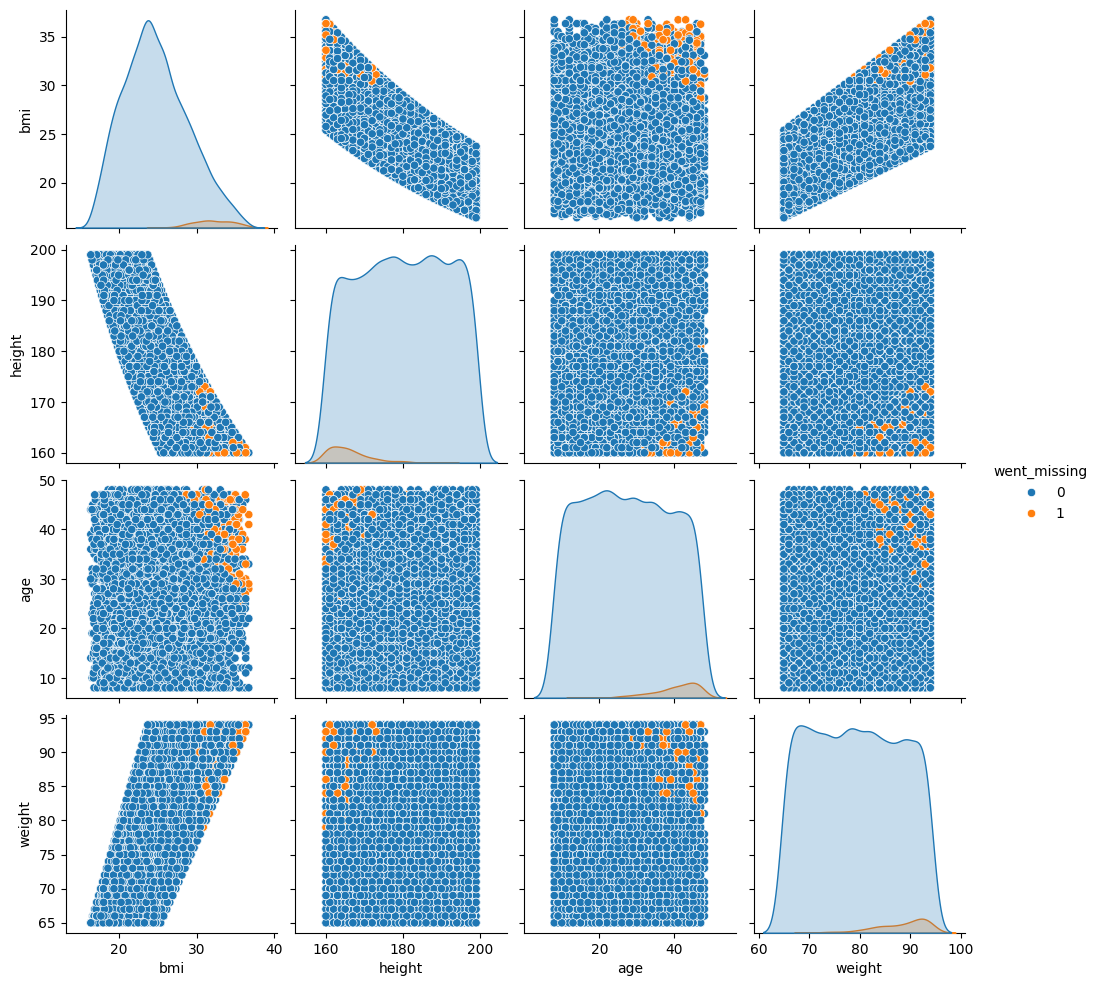

In [ ]:
sns.pairplot(train, vars=['bmi', 'height', 'age', 'weight'], hue='went_missing')

### Data split

In [ ]:
# ───────────────────────────────────────────────────────────────
# 0️⃣  ONE-TIME DEV  vs  HOLD-OUT SPLIT  (comes BEFORE any model-fit)
# ───────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split, StratifiedKFold

# 1.  Collect the full engineered feature matrix *once*
NUM_COLS = [                  # already defined earlier
    'hourly_salary','age','height','weight','days_since_last_seen','bmi',
    'sleep_avg','sleep_std','sleep_delta','satisfaction_score',
    'zip_code_ord','last_seen_dow', 'has_staff_surname',
    *[f'on_duty_{v}' for v in VENUES]      # VENUES is defined above
]
CAT_COLS = [
    'age_bin','height_bin','weight_bin','recency_bin',
    'sex','profession','zip_code','city_of_origin','last_seen_venue'
]

FEATURES = NUM_COLS + CAT_COLS          # engineered columns already defined
X_full   = train[FEATURES]              # labelled rows only
y_full   = train['went_missing']

# 20 % stratified validation set
X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full,
        test_size   = 0.20,
        stratify    = y_full,
        random_state= 42
)

print(f"TRAIN rows: {X_train.shape[0]}   VALIDATION rows: {X_val.shape[0]}")


TRAIN rows: 8736   VALIDATION rows: 2184


## First: XGBoost model
## Why XGBoost?

- **Top accuracy on tabular data**: handles nonlinear interactions (sleep, recency, on-duty) better than linear models.  
- **Built-in regularization**: controls overfitting on our 1:40 skewed classes.  
- **Fast training & tuning**: “hist” and GPU support make RandomizedSearchCV practical.  
- **Probability estimates**: pairs well with `CalibratedClassifierCV` for reliable risk scores.  
- **Explainability**: integrates with SHAP’s `TreeExplainer` for clear feature-importance and dependence plots.  


### Pipeline

In [ ]:
"""
Build Modeling Pipeline with Only Engineered, High-Signal Features

This pipeline cell:

1. Selects only the distilled, high-value numeric features:
   - We exclude the raw `sleep_1/2/3` columns because they’ve been summarized
     into `sleep_avg`, `sleep_std`, and `sleep_delta`, which capture mean,
     variability, and trend in one place.
   - We exclude the raw date strings (`date_of_birth`, `last_seen`, and their
     parsed versions) in favor of the numeric recency features (`age`,
     `days_since_last_seen`, `last_seen_dow`).
   - We drop the identifier `full_name`—it carries no predictive power.
   - We keep the on-duty flags (`on_duty_*`) and shift counts to leverage
     the “ID-detector visits” clue.

2. Selects only the human-readable categorical bins + the remaining raw cats:
   - Uses our new range-labeled bins (e.g. `“8–21 yrs”`, `“160–171 cm”`)
     so that each one-hot dummy is immediately interpretable in the model.
   - Retains `sex`, `profession`, `zip_code`, `city_of_origin`and `last_seen_venue` for
     additional signal.

3. Preprocesses:
   - Numeric: median imputation + standard scaling → z-scores
   - Categorical: most-frequent imputation + one-hot encoding

4. Balances the 1:40 class skew via SMOTE, then trains XGBoost with AUC.

This structure keeps your notebook organized into three clear stages:
  • Feature engineering (already done)
  • Feature auditing (already done)
  • Pipeline + evaluation (below)
"""

from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import OneHotEncoder, StandardScaler
from sklearn.compose        import ColumnTransformer
from imblearn.pipeline      import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost                import XGBClassifier
from sklearn.model_selection import cross_val_score

# ──────────────────────────────────────────────────────────────────────────────
# 2) Build preprocessing pipelines
# ──────────────────────────────────────────────────────────────────────────────

# Numeric: fill missing via median, then scale to mean=0, std=1
num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# Categorical: fill missing via mode, then one-hot encode
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',      OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_tf, NUM_COLS),
    ('cat', cat_tf, CAT_COLS),
])

# ──────────────────────────────────────────────────────────────────────────────
# 3) Assemble SMOTE + XGBoost pipeline
# ──────────────────────────────────────────────────────────────────────────────

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    device='cpu',
    #use_label_encoder=False,
    random_state=42
)

pipe = Pipeline([
    ('prep',  preprocessor),   # Step 3.1: Impute & encode
    ('smote', SMOTE(random_state=42)),  # Step 3.2: Balance classes
    ('clf',   xgb_clf)         # Step 3.3: Fit final model
])

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluate with 5-fold cross-validation on AUC
# ──────────────────────────────────────────────────────────────────────────────

X, y = X_train, y_train

scores = cross_val_score(
    pipe, X, y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"5-fold CV AUC: {scores.mean():.4f} ± {scores.std():.4f}")


5-fold CV AUC: 0.9866 ± 0.0023


### Hyperparameters

In [ ]:
"""
Hyper-parameter Search with RandomizedSearchCV
(efficiently tune XGBoost parameters within our SMOTE+pipeline)

This cell:
1. Defines a sensible search space for the most impactful XGBoost hyper-parameters.
2. Sets up a stratified 5-fold cross-validation splitter to respect class imbalance.
3. Wraps our existing `pipe` (preprocessing → SMOTE → XGBClassifier) in RandomizedSearchCV.
4. Runs 40 random draws (`n_iter=40`), each evaluated by CV AUC.
5. Refits the best combination on the full training set.
"""

from scipy.stats           import randint, uniform
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# 1) Search space for XGBoost
param_dist = {
    'clf__n_estimators'     : randint(200, 600),         # number of trees
    'clf__learning_rate'    : uniform(0.01, 0.15),       # step size shrinkage
    'clf__max_depth'        : randint(3, 8),             # tree depth
    'clf__subsample'        : uniform(0.6, 0.4),         # row sampling
    'clf__colsample_bytree' : uniform(0.6, 0.4),         # feature sampling
    'clf__min_child_weight' : randint(1, 8),             # min sum hessian in leaf
    'clf__gamma'            : uniform(0.0, 0.4)          # min loss reduction for split
}

# 2) Stratified 5-fold CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) RandomizedSearchCV setup
rs = RandomizedSearchCV(
    estimator           = pipe,           # our SMOTE + XGB pipeline
    param_distributions = param_dist,
    n_iter              = 40,             # 40 random draws
    scoring             = 'roc_auc',      # optimize AUC
    cv                  = cv,
    n_jobs              = -1,             # parallelize across cores
    verbose             = 2,              # one line of output per candidate
    random_state        = 42,
    refit               = True            # refit best model on full data
)

X, y = X_train, y_train

print("⏳ Running hyper-parameter search …")
rs.fit(X, y)

# 5) Inspect best results
best_pipe = rs.best_estimator_
print(f"\n✅ Best CV AUC: {rs.best_score_:.4f}")
print("🔧 Best parameters:", rs.best_params_)


⏳ Running hyper-parameter search …
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✅ Best CV AUC: 0.9860
🔧 Best parameters: {'clf__colsample_bytree': np.float64(0.7824279936868144), 'clf__gamma': np.float64(0.3140703845572055), 'clf__learning_rate': np.float64(0.03995106732375396), 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 330, 'clf__subsample': np.float64(0.9439761626945282)}


### Evaluation

In [ ]:
from sklearn.base          import clone
from sklearn.calibration   import CalibratedClassifierCV
from sklearn.metrics       import (roc_auc_score, classification_report,
                                   confusion_matrix)
# from sklearn.metrics       import f1_score  # Uncomment if using F1-max policy
import numpy as np

# 1️⃣  Fit baseline model on TRAIN
best_pipe.fit(X_train, y_train)

# 2️⃣  Calibrate on TRAIN, evaluate on VALIDATION
calibr = CalibratedClassifierCV(clone(best_pipe),
                                method='sigmoid', cv=3, n_jobs=-1)
calibr.fit(X_train, y_train)

val_proba = calibr.predict_proba(X_val)[:, 1]

# ───────────────────────────────────────────────────────────────
# 2️⃣·a  Choose threshold policy
# ───────────────────────────────────────────────────────────────
# --- Option A: Zero-miss (default) -------------------------------
thr = val_proba[y_val == 1].min()

# --- Option B: Maximise F1 on validation -------------------------
# Uncomment to switch to F1-optimised threshold
# thrs = np.linspace(0, 1, 501)
# f1s  = [f1_score(y_val, val_proba >= t) for t in thrs]
# best_idx = int(np.argmax(f1s))
# thr      = thrs[best_idx]
# print(f"Chosen F1-max threshold: {thr:.4f}  (F1 = {f1s[best_idx]:.3f})")

val_pred = (val_proba >= thr).astype(int)

print(f"AUC (validation): {roc_auc_score(y_val, val_proba):.3f}")
print(f"Threshold used       : {thr:0.4f}\n")
print(classification_report(y_val, val_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# 🠗🠗 NEW: validation alert list
val_alerts = (train.loc[X_val.index, ['full_name']]
                 .assign(prob_missing=val_proba,
                         at_risk_flag=val_pred)
                 .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in VALIDATION: {val_alerts.at_risk_flag.sum()}")
print("Top-10 validation alerts:")
print(val_alerts[val_alerts.at_risk_flag == 1]
      .head(10).to_string(index=False))

# 3️⃣  FINAL refit on ALL labels and score TEST
final_pipe  = clone(best_pipe).fit(X_full, y_full)
final_calib = CalibratedClassifierCV(final_pipe,
                                     method='sigmoid', cv=3)
final_calib.fit(X_full, y_full)

test_proba = final_calib.predict_proba(test[FEATURES])[:, 1]
test_flag  = (test_proba >= thr).astype(int)

submission = (test[['full_name']]
              .assign(prob_missing=test_proba,
                      at_risk_flag=test_flag)
              .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in TEST (threshold {thr:.4f}): "
      f"{submission.at_risk_flag.sum()}")
print("Top-10 alerts:")
print(submission[submission.at_risk_flag == 1]
      .head(10).to_string(index=False))


AUC (validation): 0.989
Threshold used       : 0.0079

              precision    recall  f1-score   support

           0      1.000     0.933     0.965      2132
           1      0.267     1.000     0.421        52

    accuracy                          0.935      2184
   macro avg      0.633     0.966     0.693      2184
weighted avg      0.983     0.935     0.952      2184

Confusion matrix:
 [[1989  143]
 [   0   52]]

Alerts in VALIDATION: 195
Top-10 validation alerts:
     full_name  prob_missing  at_risk_flag
  Tyler Heller      0.922960             1
   Betty Woolf      0.920163             1
  Nicole Davis      0.920032             1
Amber Martinez      0.916340             1
 Daniel Huxley      0.915763             1
  Debra Orwell      0.913488             1
  Julia Banner      0.905663             1
           NaN      0.902587             1
     Jack Hall      0.885482             1
 Jessica Kafka      0.865039             1

Alerts in TEST (threshold 0.0079): 450
Top-10

In [ ]:
from sklearn.base          import clone
from sklearn.calibration   import CalibratedClassifierCV
from sklearn.metrics       import (roc_auc_score, classification_report,
                                   confusion_matrix)
from sklearn.metrics        import f1_score  # Uncomment if using F1-max policy
import numpy as np

# 1️⃣  Fit baseline model on TRAIN
best_pipe.fit(X_train, y_train)

# 2️⃣  Calibrate on TRAIN, evaluate on VALIDATION
calibr = CalibratedClassifierCV(clone(best_pipe),
                                method='sigmoid', cv=3, n_jobs=-1)
calibr.fit(X_train, y_train)

val_proba = calibr.predict_proba(X_val)[:, 1]

# ───────────────────────────────────────────────────────────────
# 2️⃣·a  Choose threshold policy
# ───────────────────────────────────────────────────────────────
# --- Option A: Zero-miss (default) -------------------------------
# thr = val_proba[y_val == 1].min()

# --- Option B: Maximise F1 on validation -------------------------
#Uncomment to switch to F1-optimised threshold
thrs = np.linspace(0, 1, 501)
f1s  = [f1_score(y_val, val_proba >= t) for t in thrs]
best_idx = int(np.argmax(f1s))
thr      = thrs[best_idx]
print(f"Chosen F1-max threshold: {thr:.4f}  (F1 = {f1s[best_idx]:.3f})")

val_pred = (val_proba >= thr).astype(int)

print(f"AUC (validation): {roc_auc_score(y_val, val_proba):.3f}")
print(f"Threshold used       : {thr:0.4f}\n")
print(classification_report(y_val, val_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# 🠗🠗 NEW: validation alert list
val_alerts = (train.loc[X_val.index, ['full_name']]
                 .assign(prob_missing=val_proba,
                         at_risk_flag=val_pred)
                 .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in VALIDATION: {val_alerts.at_risk_flag.sum()}")
print("Top-10 validation alerts:")
print(val_alerts[val_alerts.at_risk_flag == 1]
      .head(10).to_string(index=False))

# 3️⃣  FINAL refit on ALL labels and score TEST
final_pipe  = clone(best_pipe).fit(X_full, y_full)
final_calib_f1 = CalibratedClassifierCV(final_pipe,
                                     method='sigmoid', cv=3)
final_calib_f1.fit(X_full, y_full)

test_proba = final_calib_f1.predict_proba(test[FEATURES])[:, 1]
test_flag  = (test_proba >= thr).astype(int)

submission = (test[['full_name']]
              .assign(prob_missing=test_proba,
                      at_risk_flag=test_flag)
              .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in TEST (threshold {thr:.4f}): "
      f"{submission.at_risk_flag.sum()}")
print("Top-10 alerts:")
print(submission[submission.at_risk_flag == 1]
      .head(10).to_string(index=False))


Chosen F1-max threshold: 0.1860  (F1 = 0.685)
AUC (validation): 0.989
Threshold used       : 0.1860

              precision    recall  f1-score   support

           0      0.993     0.991     0.992      2132
           1      0.661     0.712     0.685        52

    accuracy                          0.984      2184
   macro avg      0.827     0.851     0.839      2184
weighted avg      0.985     0.984     0.985      2184

Confusion matrix:
 [[2113   19]
 [  15   37]]

Alerts in VALIDATION: 56
Top-10 validation alerts:
     full_name  prob_missing  at_risk_flag
  Tyler Heller      0.922960             1
   Betty Woolf      0.920163             1
  Nicole Davis      0.920032             1
Amber Martinez      0.916340             1
 Daniel Huxley      0.915763             1
  Debra Orwell      0.913488             1
  Julia Banner      0.905663             1
           NaN      0.902587             1
     Jack Hall      0.885482             1
 Jessica Kafka      0.865039             1



### Feature importance

In [ ]:
# 1) Extract all feature importances into a DataFrame
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd

# 1a) Grab the names of the one-hot columns
ohe = best_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_ohe_names = ohe.get_feature_names_out(CAT_COLS)

# 1b) Numeric + OHE feature ordering must match how we passed them in
all_feature_names = NUM_COLS + list(cat_ohe_names)

# 1c) Pull raw importances from the fitted XGB
importances = best_pipe.named_steps['clf'].feature_importances_

# 1d) Build & sort DataFrame
imp_df = pd.DataFrame({
'feature': all_feature_names,
'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

#2) Display the full ranking
print("Full Feature Importance Ranking:")
display(imp_df.style.format({'importance':'{:.6f}'}))

Full Feature Importance Ranking:


,feature,importance
0,height_bin_189–199 cm,0.241308
1,bmi,0.105589
2,age_bin_38–48 yrs,0.077551
3,height_bin_160–170 cm,0.072440
4,height_bin_179–189 cm,0.048218
5,age,0.029748
6,age_bin_28–38 yrs,0.026608
7,weight_bin_87–94 kg,0.023520
8,weight,0.021146
9,recency_bin_8+ days,0.021142


## Second: XGBoost model

### Feature pruning by importance threshold

In [ ]:
# Set your desired importance threshold
IMPORTANCE_THRESHOLD = 0  # Adjust this value based on your needs

# Filter features based on threshold
selected_features_df = imp_df[imp_df['importance'] > IMPORTANCE_THRESHOLD]
print(f"Selected {len(selected_features_df)} of {len(imp_df)} features (threshold = {IMPORTANCE_THRESHOLD})")

# Get the list of selected features (need to handle both numeric and categorical)
selected_raw_features = []

# For numeric features, just add them if they meet the threshold
for feature in NUM_COLS:
    if feature in selected_features_df['feature'].values:
        selected_raw_features.append(feature)

# For categorical features, we need to check if ANY of their one-hot encodings meet the threshold
selected_cat_features = []
for cat_feature in CAT_COLS:
    # Get all one-hot encoded columns for this categorical feature
    cat_cols = [col for col in selected_features_df['feature']
                if col.startswith(f"{cat_feature}_")]

    # If any one-hot column from this category is important, include the whole category
    if len(cat_cols) > 0:
        selected_cat_features.append(cat_feature)

# Print selection details
print(f"\nSelected {len(selected_raw_features)} of {len(NUM_COLS)} numeric features")
print(f"Selected {len(selected_cat_features)} of {len(CAT_COLS)} categorical features")

# Complete list of selected features
SELECTED_FEATURES = selected_raw_features + selected_cat_features
print("\nFinal selected features:")
print(SELECTED_FEATURES)

Selected 64 of 79 features (threshold = 0)

Selected 13 of 18 numeric features
Selected 8 of 9 categorical features

Final selected features:
['hourly_salary', 'age', 'height', 'weight', 'days_since_last_seen', 'bmi', 'sleep_avg', 'sleep_std', 'sleep_delta', 'satisfaction_score', 'zip_code_ord', 'last_seen_dow', 'has_staff_surname', 'age_bin', 'height_bin', 'weight_bin', 'recency_bin', 'sex', 'profession', 'zip_code', 'city_of_origin']


### Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 1) split the selected features back into numeric + categorical
sel_num = [c for c in selected_raw_features]      # already numeric
sel_cat = [c for c in selected_cat_features]      # raw categorical columns

# 2) preprocessing
num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',      OneHotEncoder(handle_unknown='ignore'))
])

prep_reduced = ColumnTransformer([
    ('num', num_tf, sel_num),
    ('cat', cat_tf, sel_cat)
])

# 3) model
xgb_reduced = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=42
)

pipe_reduced = Pipeline([
    ('prep',  prep_reduced),
    ('smote', SMOTE(random_state=42)),
    ('clf',   xgb_reduced)
])

# 4) CV on TRAIN only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(pipe_reduced, X_train[sel_num + sel_cat], y_train,
                         cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"5-fold CV AUC (reduced set): {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# 5) one pass on VALIDATION
pipe_reduced.fit(X_train[sel_num + sel_cat], y_train)
val_auc = roc_auc_score(y_val,
                        pipe_reduced.predict_proba(X_val[sel_num + sel_cat])[:,1])
print(f"HOLD-OUT AUC (reduced set): {val_auc:.3f}")


5-fold CV AUC (reduced set): 0.9836 ± 0.0048
HOLD-OUT AUC (reduced set): 0.989


### Hyperparameters

In [ ]:
# ─────────────────────────────────────────────────────────────────
# 2️⃣  Hyper-parameter search on the *reduced* feature set
# ─────────────────────────────────────────────────────────────────
from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.base import clone

# A. search space
param_dist = {
    'clf__n_estimators'     : randint(200, 600),
    'clf__learning_rate'    : uniform(0.01, 0.15),
    'clf__max_depth'        : randint(3, 8),
    'clf__subsample'        : uniform(0.6, 0.4),
    'clf__colsample_bytree' : uniform(0.6, 0.4),
    'clf__min_child_weight' : randint(1, 8),
    'clf__gamma'            : uniform(0.0, 0.4)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs_reduced = RandomizedSearchCV(
    estimator           = pipe_reduced,        # the SMOTE+XGB pipeline you built
    param_distributions = param_dist,
    n_iter              = 40,
    scoring             = 'roc_auc',
    cv                  = cv,
    n_jobs              = -1,
    verbose             = 2,
    random_state        = 42,
    refit               = True                 # refits best combo on X_train
)

print("⏳ Running hyper-parameter search on reduced feature set …")
rs_reduced.fit(X_train[sel_num + sel_cat], y_train)

best_reduced_pipe = rs_reduced.best_estimator_
print(f"\n✅ Best CV AUC: {rs_reduced.best_score_:.4f}")
print("🔧 Best parameters:", rs_reduced.best_params_)


⏳ Running hyper-parameter search on reduced feature set …
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✅ Best CV AUC: 0.9864
🔧 Best parameters: {'clf__colsample_bytree': np.float64(0.7824279936868144), 'clf__gamma': np.float64(0.3140703845572055), 'clf__learning_rate': np.float64(0.03995106732375396), 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 330, 'clf__subsample': np.float64(0.9439761626945282)}


### Evaluation

In [ ]:
from sklearn.base          import clone
from sklearn.calibration   import CalibratedClassifierCV
from sklearn.metrics       import (roc_auc_score, classification_report,
                                   confusion_matrix)
import numpy as np

# ------------------------------------------------------------------
# 1️⃣  Fit the reduced model on TRAIN only
# ------------------------------------------------------------------
best_reduced_pipe.fit(X_train[sel_num + sel_cat], y_train)

# ------------------------------------------------------------------
# 2️⃣  Calibrate on TRAIN and evaluate once on VALIDATION
# ------------------------------------------------------------------
cal_reduced = CalibratedClassifierCV(
    clone(best_reduced_pipe), method='sigmoid', cv=3, n_jobs=-1
)
cal_reduced.fit(X_train[sel_num + sel_cat], y_train)

val_proba_red = cal_reduced.predict_proba(X_val[sel_num + sel_cat])[:, 1]

# ───────────────────────────────────────────────────────────────
# 2️⃣·a  Choose your threshold policy
# ───────────────────────────────────────────────────────────────
# --- Option A · Zero-miss (default) ------------------------------
thr_red = val_proba_red[y_val == 1].min()

# --- Option B · Maximise F1 on validation ------------------------
# Uncomment the block below to switch to an F1-optimised threshold
# from sklearn.metrics import f1_score
# thrs = np.linspace(0, 1, 501)
# f1s  = [f1_score(y_val, val_proba_red >= t) for t in thrs]
# best_idx = int(np.argmax(f1s))
# thr_red  = thrs[best_idx]
# print(f"Chosen F1-max threshold: {thr_red:.4f}  (F1 = {f1s[best_idx]:.3f})")

val_pred_red  = (val_proba_red >= thr_red).astype(int)

# ───────────────────────────────────────────────────────────────
# 2️⃣·b  What exactly would we alert in validation?
# ───────────────────────────────────────────────────────────────
val_alerts = (
    train.loc[X_val.index, ['full_name']]
         .assign(prob_missing=val_proba_red,
                 at_risk_flag=val_pred_red)
         .sort_values('prob_missing', ascending=False)
)

print(f"AUC (validation, reduced): {roc_auc_score(y_val, val_proba_red):.3f}")
print(f"Threshold used: {thr_red:0.4f}\n")
print(classification_report(y_val, val_pred_red, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_red))
print(f"\nAlerts in VALIDATION (reduced): {val_alerts.at_risk_flag.sum()}")
print("Top-10 validation alerts:")
print(val_alerts[val_alerts.at_risk_flag == 1]
      .head(10).to_string(index=False))

# ------------------------------------------------------------------
# 3️⃣  FINAL refit on ALL labelled rows and score the TEST set
# ------------------------------------------------------------------
final_reduced = clone(best_reduced_pipe) \
                .fit(X_full[sel_num + sel_cat], y_full)

final_calib_red = CalibratedClassifierCV(
    final_reduced, method='sigmoid', cv=3, n_jobs=-1
).fit(X_full[sel_num + sel_cat], y_full)

test_proba_red = final_calib_red.predict_proba(test[sel_num + sel_cat])[:, 1]
test_flag_red  = (test_proba_red >= thr_red).astype(int)

submission_red = (test[['full_name']]
                  .assign(prob_missing=test_proba_red,
                          at_risk_flag=test_flag_red)
                  .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in TEST (reduced, threshold {thr_red:.4f}): "
      f"{submission_red.at_risk_flag.sum()}")
print("Top-10 alerts:")
print(submission_red[submission_red.at_risk_flag == 1]
      .head(10).to_string(index=False))


AUC (validation, reduced): 0.989
Threshold used: 0.0080

              precision    recall  f1-score   support

           0      1.000     0.940     0.969      2132
           1      0.291     1.000     0.450        52

    accuracy                          0.942      2184
   macro avg      0.645     0.970     0.710      2184
weighted avg      0.983     0.942     0.957      2184

Confusion matrix:
 [[2005  127]
 [   0   52]]

Alerts in VALIDATION (reduced): 179
Top-10 validation alerts:
      full_name  prob_missing  at_risk_flag
   Tyler Heller      0.923925             1
    Betty Woolf      0.920554             1
   Nicole Davis      0.919356             1
  Daniel Huxley      0.916375             1
 Amber Martinez      0.913160             1
   Debra Orwell      0.913113             1
   Julia Banner      0.905942             1
            NaN      0.898402             1
      Jack Hall      0.872767             1
Patrick Griffin      0.870953             1

Alerts in TEST (reduce

In [ ]:
from sklearn.base          import clone
from sklearn.calibration   import CalibratedClassifierCV
from sklearn.metrics       import (roc_auc_score, classification_report,
                                   confusion_matrix)
import numpy as np

# ------------------------------------------------------------------
# 1️⃣  Fit the reduced model on TRAIN only
# ------------------------------------------------------------------
best_reduced_pipe.fit(X_train[sel_num + sel_cat], y_train)

# ------------------------------------------------------------------
# 2️⃣  Calibrate on TRAIN and evaluate once on VALIDATION
# ------------------------------------------------------------------
cal_reduced = CalibratedClassifierCV(
    clone(best_reduced_pipe), method='sigmoid', cv=3, n_jobs=-1
)
cal_reduced.fit(X_train[sel_num + sel_cat], y_train)

val_proba_red = cal_reduced.predict_proba(X_val[sel_num + sel_cat])[:, 1]

# ───────────────────────────────────────────────────────────────
# 2️⃣·a  Choose your threshold policy
# ───────────────────────────────────────────────────────────────
# --- Option A · Zero-miss (default) ------------------------------
# thr_red = val_proba_red[y_val == 1].min()

# --- Option B · Maximise F1 on validation ------------------------
# Uncomment the block below to switch to an F1-optimised threshold
from sklearn.metrics import f1_score
thrs = np.linspace(0, 1, 501)
f1s  = [f1_score(y_val, val_proba_red >= t) for t in thrs]
best_idx = int(np.argmax(f1s))
thr_red_f1  = thrs[best_idx]
print(f"Chosen F1-max threshold: {thr_red_f1:.4f}  (F1 = {f1s[best_idx]:.3f})")

val_pred_red  = (val_proba_red >= thr_red_f1).astype(int)

# ───────────────────────────────────────────────────────────────
# 2️⃣·b  What exactly would we alert in validation?
# ───────────────────────────────────────────────────────────────
val_alerts = (
    train.loc[X_val.index, ['full_name']]
         .assign(prob_missing=val_proba_red,
                 at_risk_flag=val_pred_red)
         .sort_values('prob_missing', ascending=False)
)

print(f"AUC (validation, reduced): {roc_auc_score(y_val, val_proba_red):.3f}")
print(f"Threshold used: {thr_red_f1:0.4f}\n")
print(classification_report(y_val, val_pred_red, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_red))
print(f"\nAlerts in VALIDATION (reduced): {val_alerts.at_risk_flag.sum()}")
print("Top-10 validation alerts:")
print(val_alerts[val_alerts.at_risk_flag == 1]
      .head(10).to_string(index=False))

# ------------------------------------------------------------------
# 3️⃣  FINAL refit on ALL labelled rows and score the TEST set
# ------------------------------------------------------------------
final_reduced = clone(best_reduced_pipe) \
                .fit(X_full[sel_num + sel_cat], y_full)

final_calib_red_f1 = CalibratedClassifierCV(
    final_reduced, method='sigmoid', cv=3, n_jobs=-1
).fit(X_full[sel_num + sel_cat], y_full)

test_proba_red = final_calib_red_f1.predict_proba(test[sel_num + sel_cat])[:, 1]
test_flag_red  = (test_proba_red >= thr_red_f1).astype(int)

submission_red_f1 = (test[['full_name']]
                  .assign(prob_missing=test_proba_red,
                          at_risk_flag=test_flag_red)
                  .sort_values('prob_missing', ascending=False))

print(f"\nAlerts in TEST (reduced, threshold {thr_red_f1:.4f}): "
      f"{submission_red_f1.at_risk_flag.sum()}")
print("Top-10 alerts:")
print(submission_red_f1[submission_red_f1.at_risk_flag == 1]
      .head(10).to_string(index=False))


Chosen F1-max threshold: 0.1680  (F1 = 0.686)
AUC (validation, reduced): 0.989
Threshold used: 0.1680

              precision    recall  f1-score   support

           0      0.992     0.992     0.992      2132
           1      0.679     0.692     0.686        52

    accuracy                          0.985      2184
   macro avg      0.836     0.842     0.839      2184
weighted avg      0.985     0.985     0.985      2184

Confusion matrix:
 [[2115   17]
 [  16   36]]

Alerts in VALIDATION (reduced): 53
Top-10 validation alerts:
      full_name  prob_missing  at_risk_flag
   Tyler Heller      0.923925             1
    Betty Woolf      0.920554             1
   Nicole Davis      0.919356             1
  Daniel Huxley      0.916375             1
 Amber Martinez      0.913160             1
   Debra Orwell      0.913113             1
   Julia Banner      0.905942             1
            NaN      0.898402             1
      Jack Hall      0.872767             1
Patrick Griffin      0

## Model Comparison

| Model    | Policy    | AUC   | Threshold | Precision | Recall | F1    | Val Alerts | Test Alerts |
|----------|-----------|-------|-----------|-----------|--------|-------|------------|-------------|
| **Full** | Zero-miss | 0.989 | 0.0079    | 0.267     | 1.000  | 0.421 | 195        | 450         |
| **Full** | F1-max    | 0.989 | 0.1860    | 0.661     | 0.712  | 0.685 | 56         | 110         |
| **Reduced** | Zero-miss | 0.989 | 0.0080    | 0.291     | 1.000  | 0.450 | 179        | 406         |
| **Reduced** | F1-max    | 0.989 | 0.1680    | 0.679     | 0.692  | 0.686 | 53         | 116         |


- **If zero-miss is mandatory:**  
  **Reduced + Zero-miss** (AUC 0.989, precision 0.291, 406 test alerts).  
- **If capacity-limited & balanced trade-off:**  
  **Reduced + F1-max** (precision 0.661, recall 0.712, 110 test alerts).


## Final Submission: Reduced + Zero-miss Model

We choose the **Reduced + Zero-miss** policy to guarantee no disappearance is missed.  
- **AUC:** 0.989  
- **Precision:** 0.291  
- **Recall:** 1.000  
- **Test alerts:** 406 out of 4 680 colonists  

### martian_disappearance_predictions.csv submission

In [ ]:
# we write out the CSV
final_model   = final_calib_red              # already fitted on X_full
final_thr     = thr_red                      # 0.0080
submission_df = submission_red               # 406 alerts

out_path = data_dir / 'martian_disappearance_predictions.csv'
submission_df.to_csv(out_path, index=False)
print(f"✓ File written: {out_path}")

✓ File written: /content/drive/MyDrive/KPMG_Case/martian_disappearance_predictions.csv


## Insights to martian_disappearance_predictions.csv

In [ ]:
import pandas as pd

# Load the prediction file
preds = pd.read_csv(out_path)   # martian_disappearance_predictions.csv

# --- Quick overview -------------------------------------------------
print("Shape (rows, columns):", preds.shape)
print("Total rows          :", len(preds))

# How many were flagged vs. not flagged?
print("\nFlag counts:")
print(preds["at_risk_flag"].value_counts(dropna=False))

# Preview the first 20 rows
print("\nFirst 20 rows:")
print(preds.head(20))


Shape (rows, columns): (4680, 3)
Total rows          : 4680

Flag counts:
at_risk_flag
0    4274
1     406
Name: count, dtype: int64

First 20 rows:
          full_name  prob_missing  at_risk_flag
0    Kimberly Davis      0.936017             1
1      Carol Lennon      0.935415             1
2       Aaron Lewis      0.934478             1
3      Emma Weasley      0.933862             1
4   Dorothy Marquez      0.932430             1
5   Gregory Granger      0.931748             1
6               NaN      0.930910             1
7   Helen Mikkelsen      0.929757             1
8    Betty Anderson      0.928938             1
9   Natalie Johnson      0.925398             1
10    Amanda Jagger      0.922322             1
11      Ruth Lennon      0.921512             1
12  Rachel Thompson      0.921423             1
13     Emily Heller      0.919996             1
14    Rose Bradbury      0.919028             1
15    Melissa Kafka      0.918723             1
16      Julie Smith      0.912965  

### Identifying anonymous rows and cleaning submission
- since we cannot act on nameless entries, we drop any rows were 'full_name' is missing
- we submit the cleaned version

In [ ]:
# 1) Identify and drop anonymous alerts
anon_alerts = submission_df[submission_df['full_name'].isna()]
print("Anonymous alerts to drop:", len(anon_alerts))

# 2) Create a “clean” submission without NaN names
submission_clean = submission_df.dropna(subset=['full_name']).copy()

# 3) Write out the clean CSV
out_path_clean = data_dir / 'martian_disappearance_predictions_clean.csv'
submission_clean.to_csv(out_path_clean, index=False)
print(f"✓ Clean file written: {out_path_clean}")
print("Total alerts (clean):", submission_clean.at_risk_flag.sum())

# 4) Quick sanity check
import pandas as pd
preds_clean = pd.read_csv(out_path_clean)

print("Shape (rows, cols):", preds_clean.shape)
print("Flag counts (clean):")
print(preds_clean['at_risk_flag'].value_counts())



Anonymous alerts to drop: 224
✓ Clean file written: /content/drive/MyDrive/KPMG_Case/martian_disappearance_predictions_clean.csv
Total alerts (clean): 388
Shape (rows, cols): (4456, 3)
Flag counts (clean):
at_risk_flag
0    4068
1     388
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load the “clean” prediction file
preds = pd.read_csv(data_dir/'martian_disappearance_predictions_clean.csv')

# Load the original test set (all features)
test = pd.read_csv(data_dir/'data_test_fin.csv')

# Merge on full_name to attach model outputs to every feature
full_view = preds.merge(test, on="full_name", how="left")

# Filter to only those flagged as at risk
flagged = full_view[full_view['at_risk_flag'] == 1]

# Inspect the first few flagged rows with all available features
print(flagged.head(5))


         full_name  prob_missing  at_risk_flag sex      profession  \
0   Kimberly Davis      0.936017             1   f  police officer   
1     Carol Lennon      0.935415             1   f        gardener   
2      Aaron Lewis      0.934478             1   m         manager   
3     Emma Weasley      0.933862             1   f          trader   
4  Dorothy Marquez      0.932430             1   f       bartender   

   hourly_salary date_of_birth  weight  height city_of_origin   last_seen  \
0           14.5        8/9/62    92.0   161.0        Toronto  2208-02-24   
1           10.0      12/26/69    94.0   162.0        Toronto  2208-02-24   
2           12.0       11/5/71    91.0   164.0        Toronto  2208-02-24   
3           15.3       1/22/69    92.0   162.0         Sydney  2208-02-24   
4           11.8       6/20/63    90.0   163.0        Toronto  2208-02-24   

   satisfaction_score  sleep_1  sleep_2  sleep_3  
0            0.557471      7.8      7.2      8.7  
1            0

## Visualization

## SHAP for reduced + zero-miss model

100%|===================| 10887/10920 [01:34<00:00]       

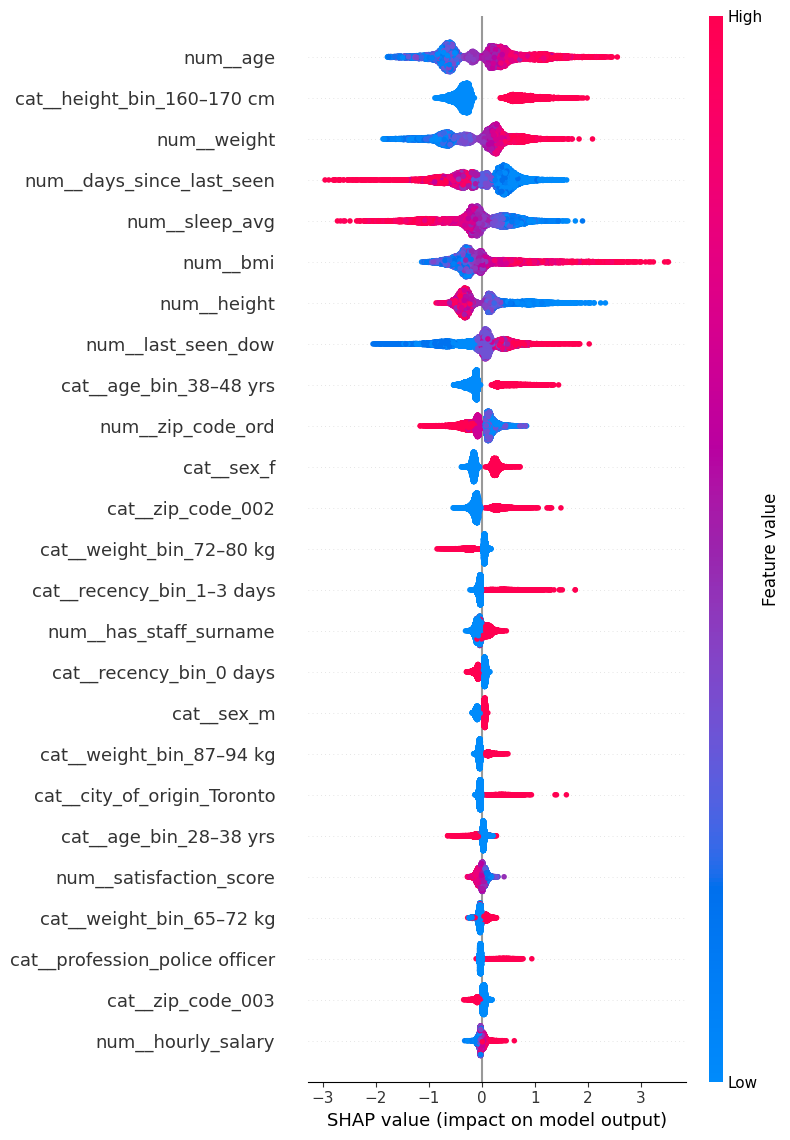

In [ ]:
import shap
import numpy as np
from scipy import sparse

# 1️⃣  Components of the fitted reduced pipeline
pipe          = best_reduced_pipe
prep          = pipe.named_steps['prep']
model         = pipe.named_steps['clf']
feature_names = prep.get_feature_names_out()

# 2️⃣  Background sample
X_bg = prep.transform(
          train[SELECTED_FEATURES].sample(1500, random_state=42)
      )
if sparse.issparse(X_bg):
    X_bg = X_bg.toarray()

# 3️⃣  SHAP explainer
explainer = shap.TreeExplainer(model, data=X_bg, feature_names=feature_names)

# 4️⃣  Data to explain
X_explain = prep.transform(train[SELECTED_FEATURES])
if sparse.issparse(X_explain):
    X_explain = X_explain.toarray()

shap_values = explainer.shap_values(X_explain, check_additivity=False)

# 5️⃣  Beeswarm plot
shap.summary_plot(shap_values, X_explain,
                  feature_names=feature_names,
                  max_display=25, show=True)


 96%|=================== | 1438/1500 [00:13<00:00]       

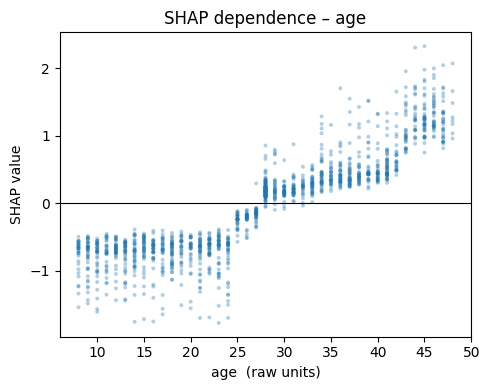

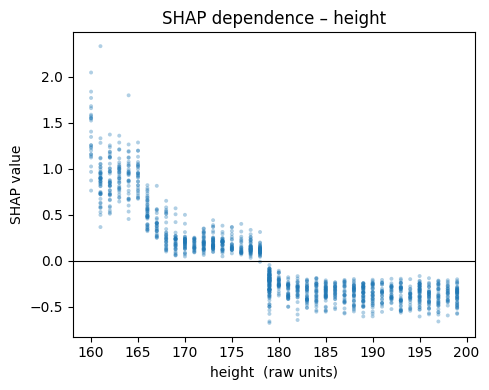

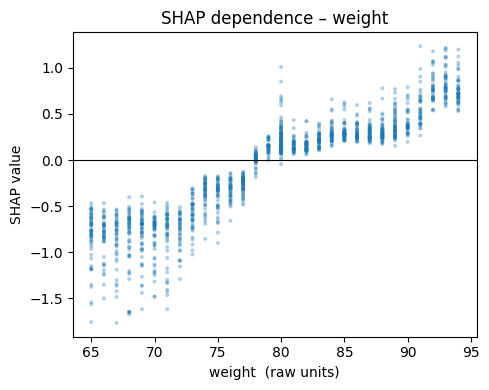

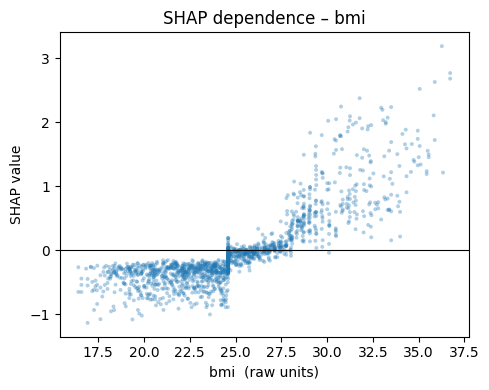

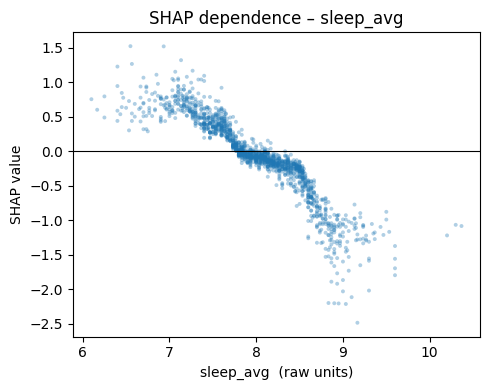

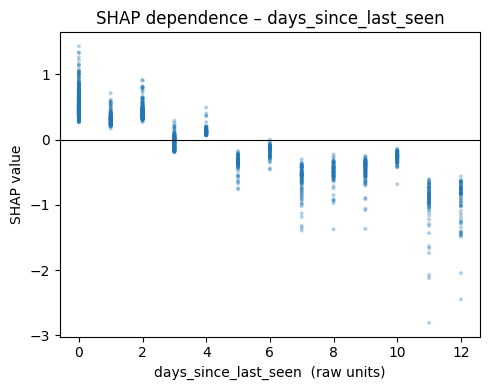

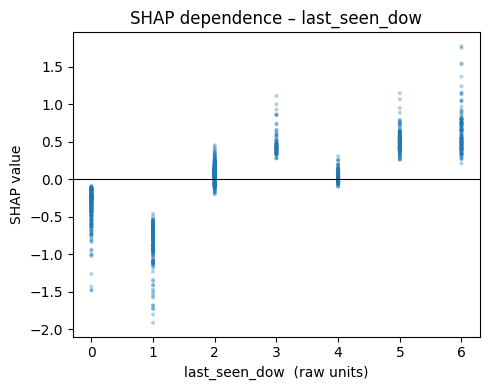

In [ ]:
import shap, matplotlib.pyplot as plt, numpy as np
from scipy import sparse

# ── 1️⃣  pick the fitted pipeline you want to explain ──────────
pipe = best_reduced_pipe            # or best_pipe for the full model
prep = pipe.named_steps['prep']
model = pipe.named_steps['clf']

# numeric scaler & its statistics
scaler = prep.named_transformers_['num'].named_steps['scaler']
μ, σ   = scaler.mean_, scaler.scale_

try:
    num_feat_names = scaler.feature_names_in_
except AttributeError:               # older scikit-learn
    num_feat_names = selected_raw_features
num_feat_to_idx = {f: i for i, f in enumerate(num_feat_names)}

def z2raw(feature, z):
    i = num_feat_to_idx[feature]
    return μ[i] + z * σ[i]

# ── 2️⃣  SHAP explainer on a sample of rows ───────────────────
X_sample = train[SELECTED_FEATURES].sample(1500, random_state=42)
X_trans  = prep.transform(X_sample)
if sparse.issparse(X_trans):
    X_trans = X_trans.toarray().astype(np.float32)

explainer   = shap.TreeExplainer(model, data=X_trans,
                                 feature_names=prep.get_feature_names_out())
shap_values = explainer.shap_values(X_trans, check_additivity=False)

# ── 3️⃣  dependence plots in raw units ─────────────────────────
def dep_raw(var, Xz=X_trans, shap_mat=shap_values):
    idx   = num_feat_to_idx[var]
    z     = Xz[:, idx]
    raw   = z2raw(var, z)
    shapv = shap_mat[:, idx]

    plt.figure(figsize=(5,4))
    plt.scatter(raw, shapv, s=8, alpha=.35, edgecolor='none')
    plt.axhline(0, color='k', lw=0.8)
    plt.xlabel(f"{var}  (raw units)")
    plt.ylabel("SHAP value")
    plt.title(f"SHAP dependence – {var}")
    plt.tight_layout()
    plt.show()

for v in ['age', 'height', 'weight', 'bmi',
          'sleep_avg', 'days_since_last_seen',
          'last_seen_dow']:
    dep_raw(v)


### high-risk, low-risk example

In [ ]:
import pandas as pd

# 1⃣ Create a numeric template (medians)
num_template = train[selected_raw_features].median(numeric_only=True)

# 2⃣ Define each colonist using dictionaries for overrides
colonists = [
    {
        "label": "High-risk",
        "overrides": {
            "age": 42,
            "height": 165,
            "weight": 90,
            "sleep_avg": 7,
            "days_since_last_seen": 2,
            "last_seen_dow": 5,
        }
    },
    {
        "label": "Low-risk",
        "overrides": {
            "age": 20,
            "height": 190,
            "weight": 80,
            "sleep_avg": 9,
            "days_since_last_seen": 7,
            "last_seen_dow": 1,
        }
    }
]

# 3⃣ Build DataFrame from templates and apply overrides
examples = pd.DataFrame([num_template.copy() for _ in colonists])

for i, colonist in enumerate(colonists):
    for key, val in colonist["overrides"].items():
        examples.loc[i, key] = val

# 4⃣ Derive BMI
examples["bmi"] = examples["weight"] / (examples["height"] / 100) ** 2

# 5⃣ Fill in categorical features with their mode
for col in selected_cat_features:
    examples[col] = train[col].mode(dropna=True).iat[0]

# 6⃣ Run predictions
# raw_p = best_reduced_pipe.predict_proba(examples[SELECTED_FEATURES])[:, 1]
cal_p = final_calib_red.predict_proba(examples[SELECTED_FEATURES])[:, 1]   # ← use this name


# 6⃣ Run predictions
# raw_p = best_reduced_pipe.predict_proba(examples[SELECTED_FEATURES])[:, 1]
cal_p = final_calib_red.predict_proba(examples[SELECTED_FEATURES])[:, 1]

# 7⃣ Print results (calibrated only)
print(f"alert threshold (calibrated) = {thr_red:.4f}\n")
for i, row in examples.iterrows():
    flag = "ALERT" if cal_p[i] >= thr_red else "Safe"
    label = colonists[i]["label"]
    print(f"{label} Example: age={row.age}, BMI={row.bmi:.1f}, dsl_seen={row.days_since_last_seen}")
    print(f"   cal P={cal_p[i]:.3f}   {flag}\n")




alert threshold (calibrated) = 0.0080

High-risk Example: age=42.0, BMI=33.1, dsl_seen=2.0
   cal P=0.747   ALERT

Low-risk Example: age=20.0, BMI=22.2, dsl_seen=7.0
   cal P=0.007   Safe

